In [1]:
# %%
import os,argparse,natsort
import pandas as pd
import matplotlib.pyplot as plt
# display more columns
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
data_dir = '/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset'

In [3]:

def generate_summary_stats_per_op(data_dir):

    root_to_files = {}
    for root, dirs, files in os.walk(data_dir):
        root_to_files[root] = files
    roots = sorted(root_to_files, key=lambda x: natsort.natsort_key(x.lower()))

    config_to_stats = {}

    # recursively find all the log files
    for root in roots:
        if 'e2e' in root:
            continue
        files = root_to_files[root]
        print(root)

        # root is in the format of /mydata/pytorch_custom_log_one_epoch_imagenet_dataset/b1024_gpu4
        # get me the batch size and gpu count as 'b1024_gpu4
        root = root.rstrip('/')
        config = root.split('/')[-1]
        print(config)
        dataloader_config = config.split('dataloader')[-1]


        combine_df = pd.DataFrame()
        for file in files:
            if 'worker_pid' in file:
                fp = os.path.join(root, file)
                #  read the log file as csv with no header
                df = pd.read_csv(fp, header=None)
                df.columns = ["name", "start", "dur"]

                # drop columns with name "start"
                df = df.drop(columns=["start"])

                # divide "dur" column by 1000,000 to get time in ms
                df["dur"] = df["dur"] / 1000000
                # discard the rows with name starting with SBatch
                df = df[~df["name"].str.startswith("SBatch")]

                # concatenate all the dataframes
                combine_df = pd.concat([combine_df, df])

        # check if the dataframe is empty
        if combine_df.empty:
            continue

        stats_df = combine_df.groupby("name").agg(["sum"])

        # make the column names flat
        stats_df.columns = stats_df.columns.get_level_values(0)
        config_to_stats[dataloader_config] = stats_df
    
    return config_to_stats

        

In [4]:
# %%
print("All numbers are in ms")
config_to_stats = generate_summary_stats_per_op(data_dir)

All numbers are in ms
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset
pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/b1024_gpu4_dataloader8
b1024_gpu4_dataloader8
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/b1024_gpu4_dataloader12
b1024_gpu4_dataloader12
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/b1024_gpu4_dataloader16
b1024_gpu4_dataloader16
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/b1024_gpu4_dataloader20
b1024_gpu4_dataloader20
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/b1024_gpu4_dataloader24
b1024_gpu4_dataloader24
/mydata/pytorch_custom_log_and_vtune_one_epoch_imagenet_dataset/b1024_gpu4_dataloader28
b1024_gpu4_dataloader28


In [5]:
# concat all the stats into one dataframe make keys a columns with name "config"
all_stats_df = pd.concat(config_to_stats).reset_index() 

In [6]:
all_stats_df.head(10)

,level_0,name,dur
0,8,SCollation,5.639869e+05
1,8,SLoader,6.403771e+06
2,8,SNormalize,3.055109e+05
3,8,SRandomHorizontalFlip,9.313464e+04
4,8,SRandomResizedCrop,1.518370e+06
5,8,SToTensor,5.178513e+05
6,8,STransform,2.621928e+06
7,12,SCollation,5.901357e+05
8,12,SLoader,6.593468e+06
9,12,SNormalize,3.270434e+05


In [7]:
# replace the column name "level_0" with "config"
all_stats_df = all_stats_df.rename(columns={"level_0": "config"})
# replace the column name "dur" with "E2E elapsed time (ms)"
all_stats_df = all_stats_df.rename(columns={"dur": "E2E elapsed time (secs)"})
# replace the column name "name" with "Function"
all_stats_df = all_stats_df.rename(columns={"name": "Function"})
# cast config column as int
all_stats_df["config"] = all_stats_df["config"].astype(int)

In [8]:
# Strip leading 'S' in column 'Function'
all_stats_df['Function'] = all_stats_df['Function'].str.lstrip('S')

In [9]:
# remove column 'name' with 'STransform' 
all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Transform")]
# remove column 'name' with 'SCollation'
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Collation")]
# remove SLoader
# all_stats_df = all_stats_df[~all_stats_df["Function"].str.startswith("Loader")]

In [10]:
all_stats_df.head(10)

,config,Function,E2E elapsed time (secs)
0,8,Collation,5.639869e+05
1,8,Loader,6.403771e+06
2,8,Normalize,3.055109e+05
3,8,RandomHorizontalFlip,9.313464e+04
4,8,RandomResizedCrop,1.518370e+06
5,8,ToTensor,5.178513e+05
7,12,Collation,5.901357e+05
8,12,Loader,6.593468e+06
9,12,Normalize,3.270434e+05
10,12,RandomHorizontalFlip,1.037676e+05


In [11]:
# divide the column "E2E elapsed time (ms)" by 1000 to get time in seconds
all_stats_df["E2E elapsed time (secs)"] = all_stats_df["E2E elapsed time (secs)"] / 1000

In [12]:
print(all_stats_df.columns)

Index(['config', 'Function', 'E2E elapsed time (secs)'], dtype='object')


In [13]:
all_stats_df.head(len(all_stats_df))

,config,Function,E2E elapsed time (secs)
0,8,Collation,563.986893
1,8,Loader,6403.771336
2,8,Normalize,305.510900
3,8,RandomHorizontalFlip,93.134639
4,8,RandomResizedCrop,1518.370253
5,8,ToTensor,517.851274
7,12,Collation,590.135717
8,12,Loader,6593.468413
9,12,Normalize,327.043441
10,12,RandomHorizontalFlip,103.767641


In [14]:
want_max_diff = True

In [15]:
if want_max_diff:
    # get sum of 'E2E elapsed time (secs)' for each config
    tmp = all_stats_df.groupby('config')['E2E elapsed time (secs)'].sum().sort_values(ascending=False)
    # get the first index of tmp
    max_config = tmp.index[0]
    min_config = tmp.index[-1]
    #  print max config and min config along with the difference
    print("Max config: {}, Min config: {}, \nDifference in elapsed time: {:.2f} seconds".format(max_config, min_config, tmp[max_config] - tmp[min_config]))
    config1 = max_config
    config2 = min_config
else:
    batch_size1 = 1024
    batch_size2 = 256
    gpus1 = 4
    gpus2 = 1

    config1 = f'b{batch_size1}_gpu{gpus1}'
    config2 = f'b{batch_size2}_gpu{gpus2}'

Max config: 28, Min config: 8, 
Difference in elapsed time: 5021.02 seconds


In [16]:
# sort tmp dataframe by config
tmp.sort_index(inplace=True)

tmp

config
8      9402.625295
12     9832.074672
16    10458.421729
20    12057.382864
24    13448.627293
28    14423.645936
Name: E2E elapsed time (secs), dtype: float64

<Axes: xlabel='config'>

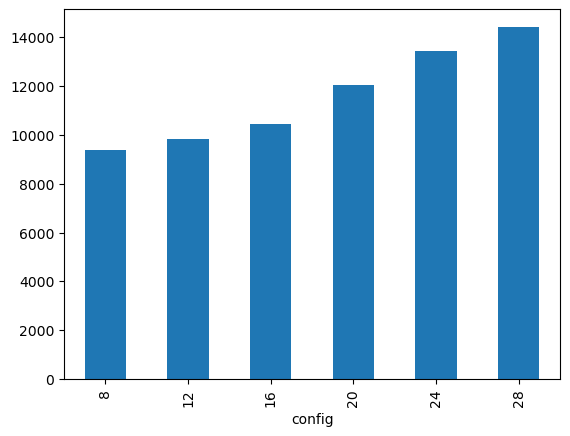

In [17]:
# plot tmp
tmp.plot.bar()

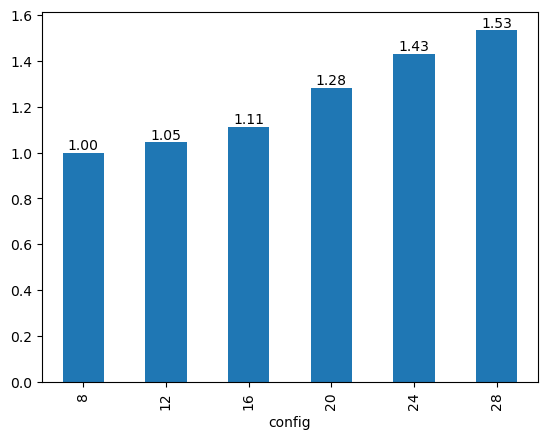

In [18]:
# divide tmp by the lowest value
tmp = tmp / tmp.min()

# plot tmp
tmp.plot.bar()
# add bar height as text
for i, v in enumerate(tmp):
    plt.text(i, v, "{:.2f}".format(v), ha='center', va='bottom')


Text(0.5, 1.0, 'Preprocessing time per operation')

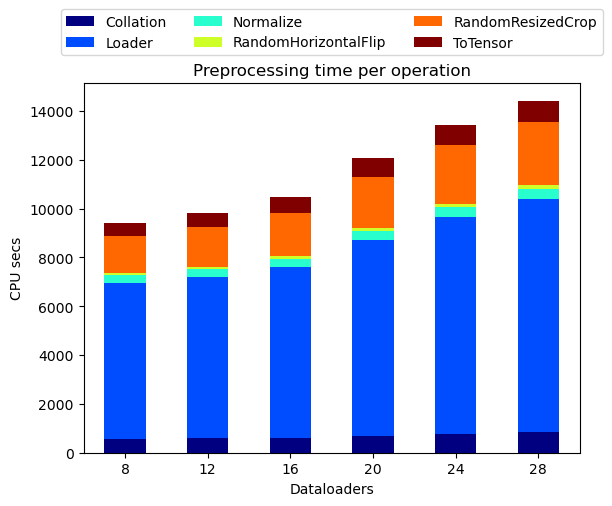

In [19]:
# plot stacked bar chart for each config
all_config_stacked = all_stats_df.groupby(['config', 'Function'])['E2E elapsed time (secs)'].sum().unstack()
all_config_stacked.plot.bar(stacked=True, colormap='jet')
# put legend on top of the plot
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0., ncol=3)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper', borderaxespad=0.,ncol=3)
# y axis is elapsed time in seconds
plt.ylabel('CPU secs')
# x axis is Dataloaders
plt.xlabel('Dataloaders')
# make x axis horizontal
plt.xticks(rotation=0)
# make title 
plt.title('Preprocessing time per operation')
# make legend horizontal on top of the title 


In [20]:
# all_config_stacked save as csv
all_config_stacked.to_csv('/mydata/rbachkaniwala3/code/rajveerb-ml-pipeline-benchmark/code/image_classification/analysis/custom_logs/all_config_stacked.csv')

In [21]:
# pretty print the difference in elapsed time
print("Difference in elapsed time {} - {} : {:.3f} seconds".format(config1,config2, tmp[config1] - tmp[config2]))

Difference in elapsed time 28 - 8 : 0.534 seconds


In [22]:
# get difference of the functions' 'E2E elapsed time (secs)' between config1 and config2
diff_df = all_stats_df[all_stats_df["config"].isin([config1, config2])].groupby(["Function", "config"]).agg(["sum"]).reset_index()
print(diff_df.head(len(diff_df)))
diff_df.columns = diff_df.columns.get_level_values(0)
diff_df["diff"] = diff_df.groupby("Function")["E2E elapsed time (secs)"].diff()
diff_df = diff_df.dropna()
diff_df = diff_df.sort_values(by=["diff"], ascending=False)
# drop column config and 'E2E elapsed time (secs)'
diff_df = diff_df.drop(columns=["config", "E2E elapsed time (secs)"])
# pretty print the difference in elapsed time
print("Difference in elapsed time {} and {} across functions".format(config1,config2))
print(diff_df.head(len(diff_df)))

                Function config E2E elapsed time (secs)
                                                    sum
0              Collation      8              563.986893
1              Collation     28              854.897752
2                 Loader      8             6403.771336
3                 Loader     28             9524.580189
4              Normalize      8              305.510900
5              Normalize     28              421.846047
6   RandomHorizontalFlip      8               93.134639
7   RandomHorizontalFlip     28              162.301185
8      RandomResizedCrop      8             1518.370253
9      RandomResizedCrop     28             2573.914097
10              ToTensor      8              517.851274
11              ToTensor     28              886.106667
Difference in elapsed time 28 and 8 across functions
                Function         diff
3                 Loader  3120.808852
9      RandomResizedCrop  1055.543844
11              ToTensor   368.255393
1          

In [23]:
# only keep cofngi values with config 'b256_gpu2' and '1024_gpu4' in all_stats_df
all_stats_df_filtered = all_stats_df[all_stats_df['config'].isin([config1, config2])]

In [24]:
all_stats_df_filtered.head(len(all_stats_df_filtered))

,config,Function,E2E elapsed time (secs)
0,8,Collation,563.986893
1,8,Loader,6403.771336
2,8,Normalize,305.510900
3,8,RandomHorizontalFlip,93.134639
4,8,RandomResizedCrop,1518.370253
5,8,ToTensor,517.851274
35,28,Collation,854.897752
36,28,Loader,9524.580189
37,28,Normalize,421.846047
38,28,RandomHorizontalFlip,162.301185


In [25]:
# pivot table with config as index and name as columns and E2E elapsed time (ms) as values
pivot_df = all_stats_df_filtered.pivot_table(index='config', columns='Function', values='E2E elapsed time (secs)')

In [26]:
# do a natsort over the config column
pivot_df = pivot_df.reindex(natsort.natsorted(pivot_df.index))

In [27]:
pivot_df.head(len(pivot_df))

Function,Collation,Loader,Normalize,RandomHorizontalFlip,RandomResizedCrop,ToTensor
config,,,,,,
8,563.986893,6403.771336,305.510900,93.134639,1518.370253,517.851274
28,854.897752,9524.580189,421.846047,162.301185,2573.914097,886.106667


Text(0, 0.5, 'E2E elapsed time (secs)')

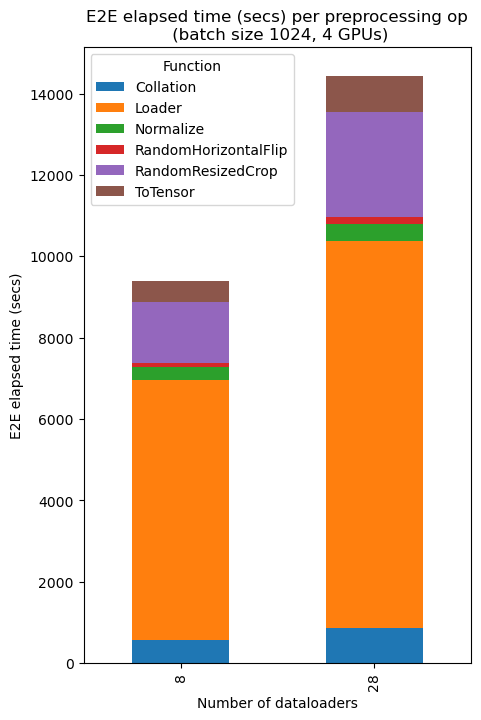

In [28]:
pivot_df.plot(kind='bar', stacked=True, figsize=(5,8))
# set the title of the plot
plt.title('E2E elapsed time (secs) per preprocessing op\n (batch size 1024, 4 GPUs)')
# set the x-axis label
plt.xlabel('Number of dataloaders')
# set the y-axis label
plt.ylabel('E2E elapsed time (secs)')

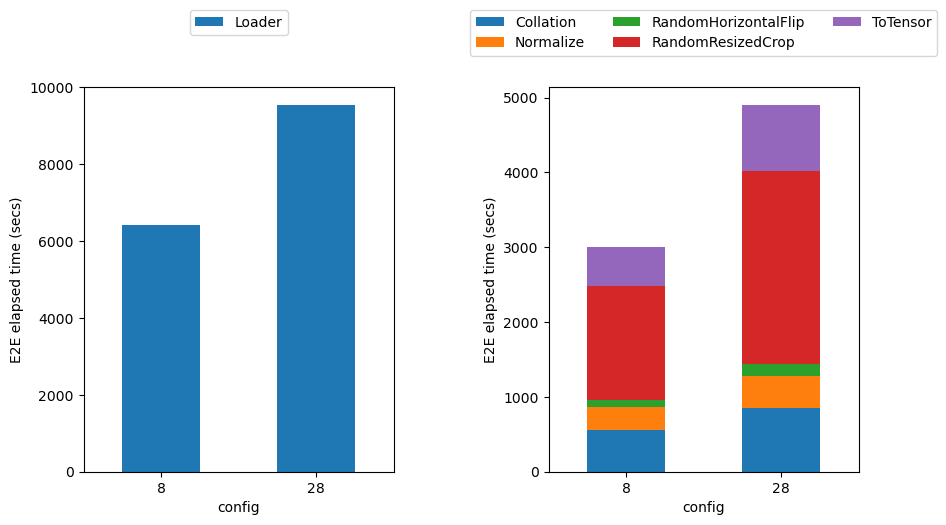

In [29]:
# get dataframe with function 'SLoader' only
pivot_df_SLoader = pivot_df[['Loader']]

# get dataframe with all functions except 'SLoader' without dropping the 'SLoader' column
pivot_df_without_SLoader = pivot_df.drop(columns=['Loader'])

# generate a subplot with above two figures
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pivot_df_SLoader.plot(kind='bar', ax=axes[0])
pivot_df_without_SLoader.plot(kind='bar', stacked=True, ax=axes[1])

# squeeze figsize of first subplot horizontally
fig.subplots_adjust(wspace=0.5)

# display legends at the top of each subplot
axes[0].legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0.)
# make legend of second subplot outside the plot at the top and make it horizontal
axes[1].legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0., ncol=3)

# set y label for first subplot
axes[0].set_ylabel('E2E elapsed time (secs)')
# set y label for second subplot
axes[1].set_ylabel('E2E elapsed time (secs)')
# set x label for first subplot
axes[0].set_xlabel('config')
# set x label for second subplot
axes[1].set_xlabel('config')

# make x axis labels horizontal for all subplots
for ax in axes:
    ax.tick_params(axis='x', labelrotation=0)
plt.show()

